In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

# LOAD DATA FOR ARIMA

In [3]:
df = pd.read_csv('data_daily.csv',parse_dates=True,index_col='# Date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m-%d')).sum()['Receipt_Count'])
df.columns=['Value']

In [4]:
df

,Value
# Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289
...,...
2021-12-27,10350408
2021-12-28,10219445
2021-12-29,10313337


# Handwritten code for ARIMA

In [5]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [6]:
# Moving Average calculation
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



# ADF Report to analyse p values, Number of Lags Used, Number of Observations Used

In [7]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

# Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

In [8]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.244391147274454
p-value : 1.5514734117839491e-15
Number of Lags Used : 16
Number of Observations Used : 335
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='# Date'>

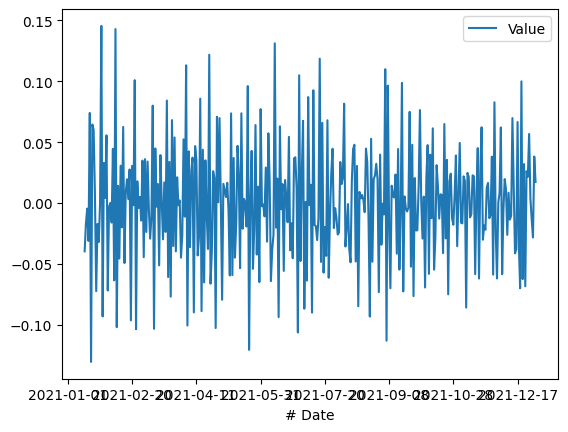

In [9]:
# print(df_testing.to_string())
df_testing.plot()

# Here we see Autocorrelation in data

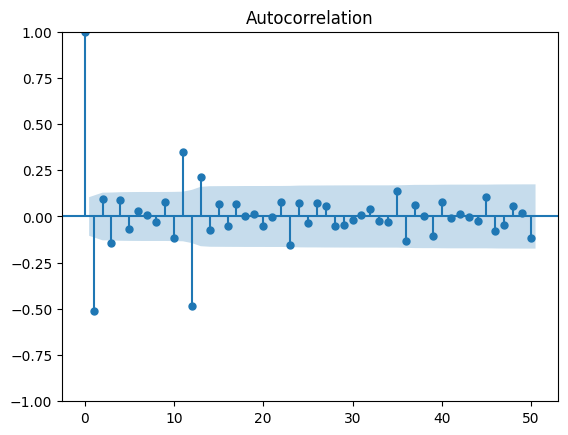

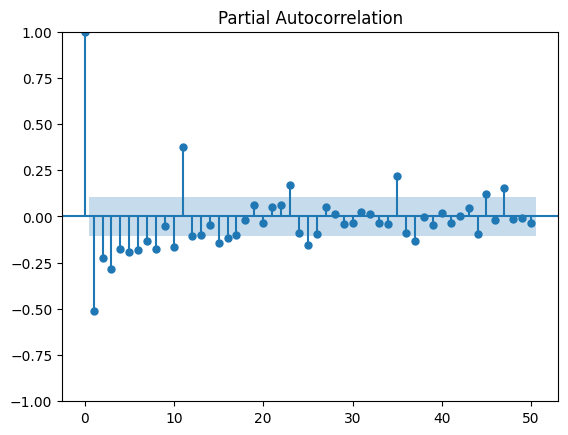

In [10]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

# Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [11]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.03684721538852029 , Value of p :  1
The RMSE is : 0.03463326809299652 , Value of p :  2
The RMSE is : 0.03256402833087074 , Value of p :  3
The RMSE is : 0.03297567835776339 , Value of p :  4
The RMSE is : 0.032913303786516926 , Value of p :  5
The RMSE is : 0.03205085197642037 , Value of p :  6
The RMSE is : 0.03292889156202869 , Value of p :  7
The RMSE is : 0.03342162540293396 , Value of p :  8
The RMSE is : 0.033019687197091356 , Value of p :  9
The RMSE is : 0.03277536107196907 , Value of p :  10
The RMSE is : 0.0308185458460252 , Value of p :  11
The RMSE is : 0.02988331901951101 , Value of p :  12
The RMSE is : 0.029188740813746866 , Value of p :  13
The RMSE is : 0.02942741386864116 , Value of p :  14
The RMSE is : 0.029058810162002967 , Value of p :  15
The RMSE is : 0.0286425547671768 , Value of p :  16
The RMSE is : 0.028542572978798766 , Value of p :  17
The RMSE is : 0.028912137156045487 , Value of p :  18
The RMSE is : 0.02903817394449066 , Value of p :  1

### Here we use the best_p calculated and it returns the theta and intercept

In [12]:
[df_train,df_test,theta_AR,intercept_AR,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.028542572978798766 , Value of p :  17


<Axes: xlabel='# Date'>

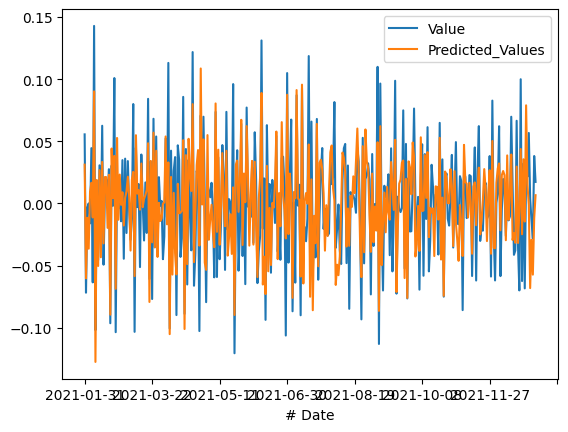

In [13]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

# Generating the residuals for MA

In [14]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [15]:
res

,Residuals
# Date,
2021-01-31,0.024345
2021-02-01,-0.011578
2021-02-02,0.008360
2021-02-03,0.036435
2021-02-04,-0.025390
...,...
2021-12-27,0.071912
2021-12-28,0.015659
2021-12-29,0.029012


<Axes: ylabel='Density'>

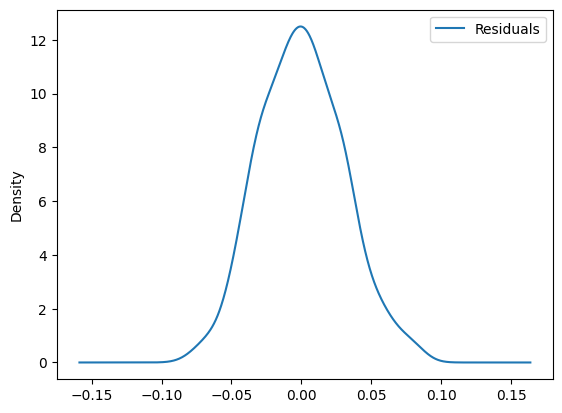

In [16]:
res.plot(kind='kde')

# Step 3 : Fitting MA on Residuals

The RMSE is : 0.02927294733637645 , Value of q :  1
The RMSE is : 0.029277012949979607 , Value of q :  2
The RMSE is : 0.029396859488988184 , Value of q :  3
The RMSE is : 0.02940730894880717 , Value of q :  4
The RMSE is : 0.02940920978774143 , Value of q :  5
The RMSE is : 0.029563113306032153 , Value of q :  6
The RMSE is : 0.029680289371280193 , Value of q :  7
The RMSE is : 0.02954760941801531 , Value of q :  8
The RMSE is : 0.02964716538727973 , Value of q :  9
The RMSE is : 0.029688476526802853 , Value of q :  10
The RMSE is : 0.029577100647219072 , Value of q :  11
The RMSE is : 0.02966247656212294 , Value of q :  12
1


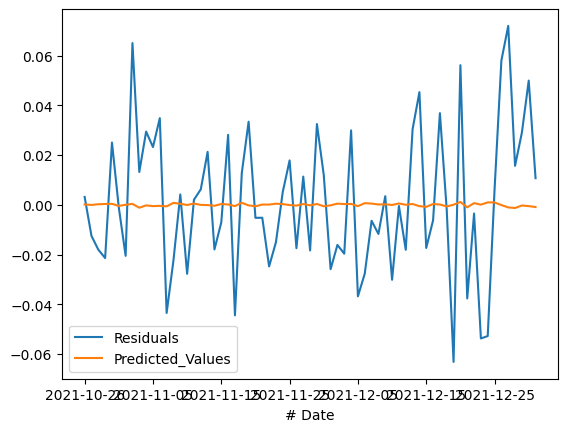

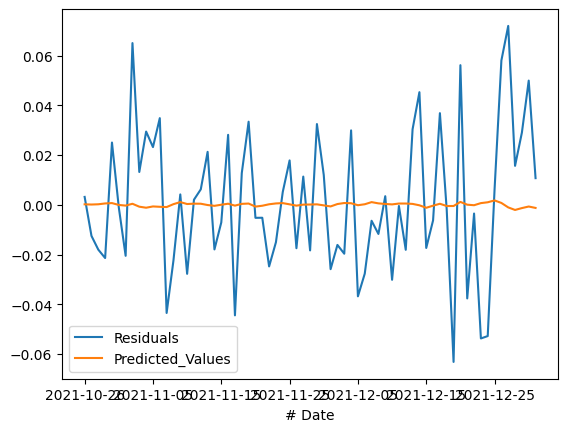

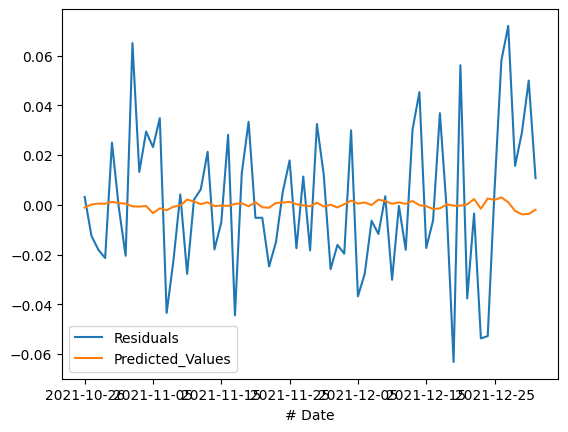

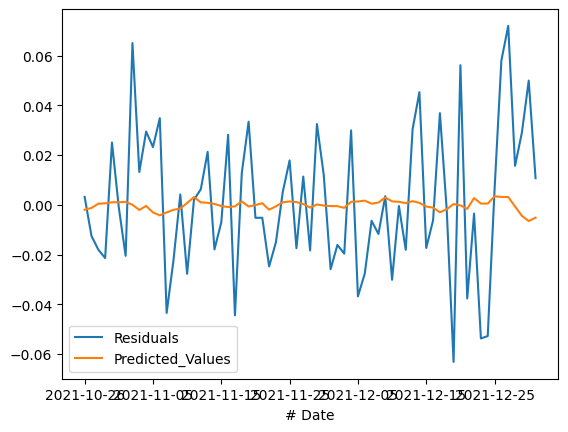

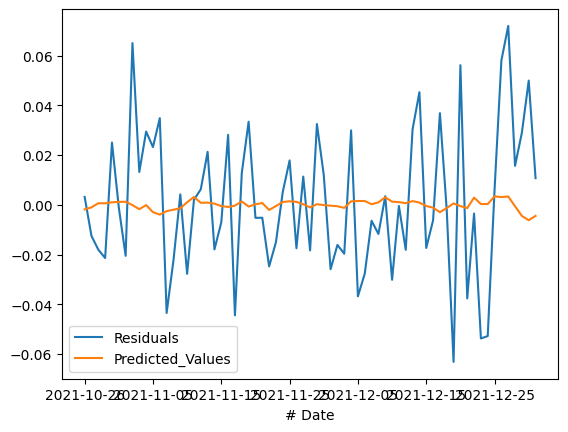

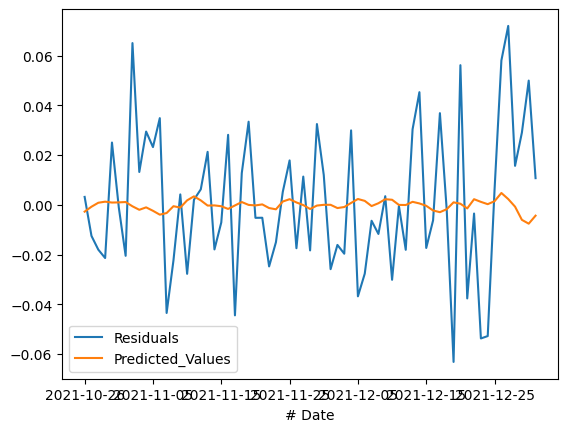

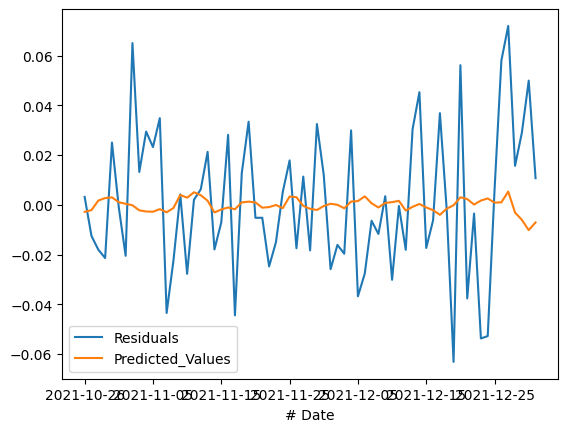

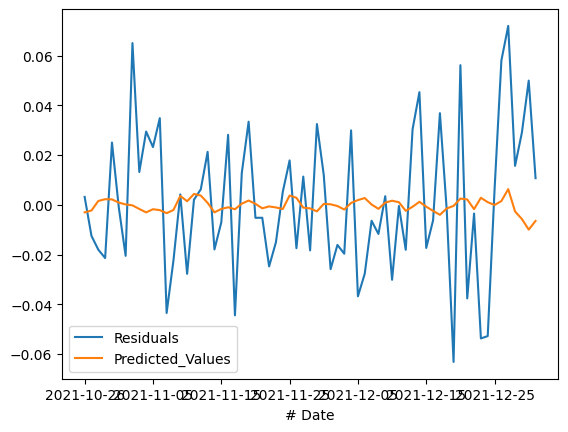

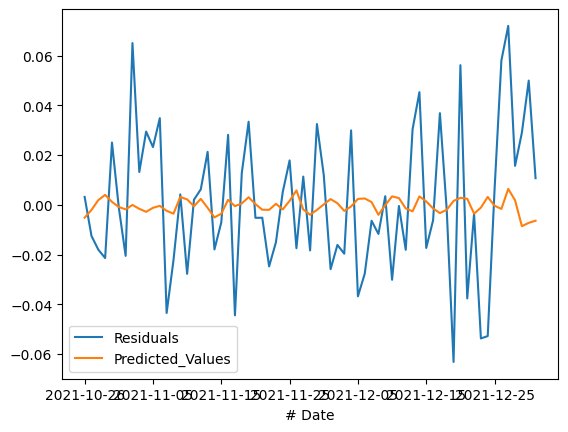

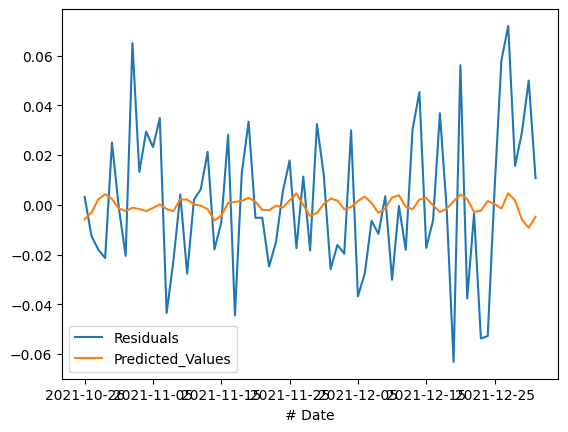

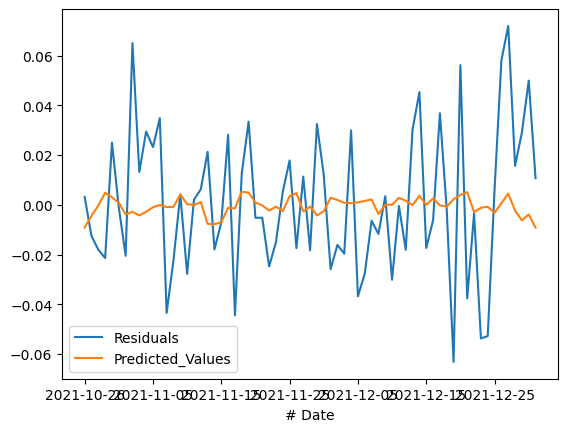

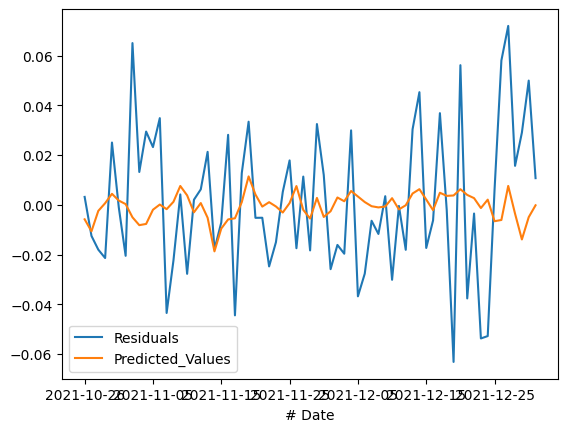

In [17]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 0.02927294733637645 , Value of q :  1
[[-0.01797144]]
[-6.01559997e-06]


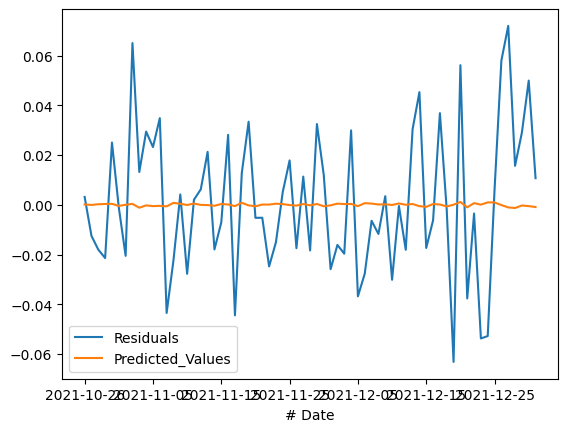

In [18]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [19]:
res_c = pd.concat([res_train,res_test])

In [20]:
res_c

,Residuals,Shifted_values_1,Predicted_Values
# Date,,,
2021-02-01,-0.011578,0.024345,-0.000444
2021-02-02,0.008360,-0.011578,0.000202
2021-02-03,0.036435,0.008360,-0.000156
2021-02-04,-0.025390,0.036435,-0.000661
2021-02-05,0.027874,-0.025390,0.000450
...,...,...,...
2021-12-27,0.071912,0.058026,-0.001049
2021-12-28,0.015659,0.071912,-0.001298
2021-12-29,0.029012,0.015659,-0.000287


In [21]:
df_c.Predicted_Values += res_c.Predicted_Values

<Axes: xlabel='# Date'>

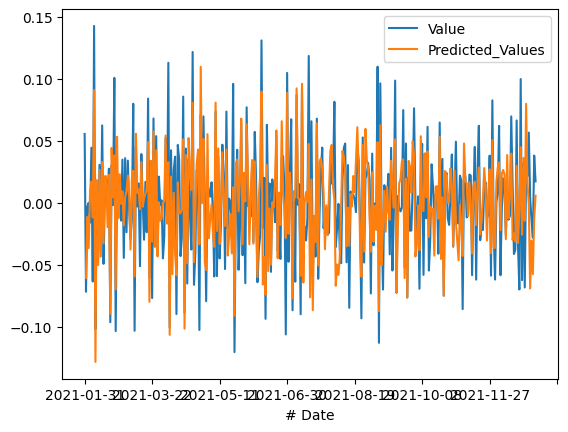

In [22]:
df_c[['Value','Predicted_Values']].plot()

In [23]:
df_ccopy=df_c.copy()

# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [24]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [26]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Shifted_values_17,Predicted_Values
# Date,,,,,,,,,,,,,,,,,,,
2021-01-31,7838129.0,0.004197,0.032964,-0.093056,0.145429,-0.000385,-0.031976,-0.017128,-0.072301,0.007429,0.060021,0.064508,-0.130396,0.073992,-0.031051,-0.004552,-0.016796,-0.039631,NaN
2021-02-01,7714465.0,0.055583,0.004197,0.032964,-0.093056,0.145429,-0.000385,-0.031976,-0.017128,-0.072301,0.007429,0.060021,0.064508,-0.130396,0.073992,-0.031051,-0.004552,-0.016796,7.800838e+06
2021-02-02,7766408.0,-0.071744,0.055583,0.004197,0.032964,-0.093056,0.145429,-0.000385,-0.031976,-0.017128,-0.072301,0.007429,0.060021,0.064508,-0.130396,0.073992,-0.031051,-0.004552,7.703307e+06
2021-02-03,7832259.0,-0.003164,-0.071744,0.055583,0.004197,0.032964,-0.093056,0.145429,-0.000385,-0.031976,-0.017128,-0.072301,0.007429,0.060021,0.064508,-0.130396,0.073992,-0.031051,7.550850e+06
2021-02-04,7506461.0,0.000088,-0.003164,-0.071744,0.055583,0.004197,0.032964,-0.093056,0.145429,-0.000385,-0.031976,-0.017128,-0.072301,0.007429,0.060021,0.064508,-0.130396,0.073992,7.694407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10350408.0,0.056707,0.021563,0.026171,-0.068278,0.032042,-0.062381,0.099924,-0.069901,-0.033877,0.066524,-0.037853,-0.041259,0.015922,0.069764,-0.010434,-0.013577,0.008506,9.622125e+06
2021-12-28,10219445.0,0.003866,0.056707,0.021563,0.026171,-0.068278,0.032042,-0.062381,0.099924,-0.069901,-0.033877,0.066524,-0.037853,-0.041259,0.015922,0.069764,-0.010434,-0.013577,1.004761e+07
2021-12-29,10313337.0,-0.013526,0.003866,0.056707,0.021563,0.026171,-0.068278,0.032042,-0.062381,0.099924,-0.069901,-0.033877,0.066524,-0.037853,-0.041259,0.015922,0.069764,-0.010434,1.001555e+07


<Axes: xlabel='# Date'>

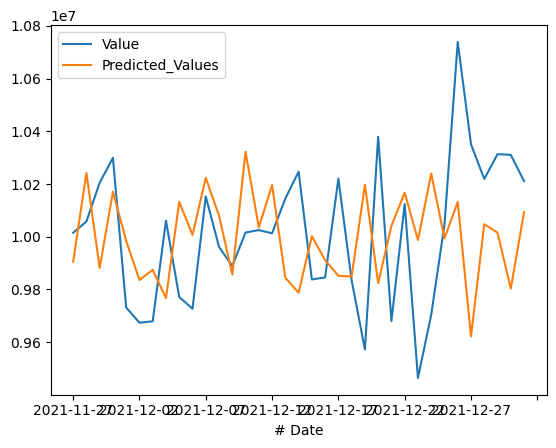

In [31]:
df_c.iloc[300:,:][['Value','Predicted_Values']].plot()

# Prediction Out of Sample Data

Here the model was not getting configured on how to send data to predict so we dropped the technique

In [67]:
from datetime import datetime
df_cpredict=df_ccopy.copy()
last_date_str = '2021-12-31'
last_date = datetime.strptime(last_date_str, '%Y-%m-%d')
vals=df_cpredict.iloc[0:best_p,0].values
vals=pd.DataFrame(vals)
vals.columns=['Value']
lagged_values = df_cpredict.iloc[-best_p-1:-1, 0:best_p].values  # Use the last 'best_p' values from df_c

# Initialize a prediction DataFrame starting from the last date
prediction_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 366)]  # Add 1 to 365 days


In [68]:
predictedvalue=lagged_values.dot(theta_AR)


In [70]:
predictedvalue += np.log(vals).shift(1).Value
predictedvalue += np.log(df).diff().shift(12).Value
predictedvalue = np.exp(predictedvalue)

/Users/anudeep/Library/Python/3.9/lib/python/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


ValueError: Data must be 1-dimensional